In [3]:
"""
Kaggle Brain MRI Dataset Visualization Script
Copy each cell section into separate Jupyter notebook cells
"""

# ============================================================
# CELL 1: Imports and Setup
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
from collections import Counter
import os

# Import our custom modules - fix paths
import sys
# Get project root (parent of scripts/ or jupyter_notebooks/)
if 'scripts' in os.getcwd():
    project_root = Path(os.getcwd()).parent
elif 'jupyter_notebooks' in os.getcwd():
    project_root = Path(os.getcwd()).parent
else:
    project_root = Path(os.getcwd())

sys.path.insert(0, str(project_root))

from src.data.kaggle_mri_dataset import KaggleBrainMRIDataset, create_dataloaders
from src.data.transforms import (
    get_train_transforms,
    get_val_transforms,
    get_strong_train_transforms,
    get_light_train_transforms,
)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("[OK] Imports successful!")
print(f"[OK] Project root: {project_root}")



[OK] Imports successful!
[OK] Project root: c:\--DPM-MAIN-DIR--\windsurf_projects\MRI-CV-MODEL-TRAINING-AND-INFERENCE-PROJECT


In [4]:

# ============================================================
# CELL 2: Load Datasets
# ============================================================
# Use absolute paths
train_dir = project_root / "data" / "processed" / "kaggle" / "train"
val_dir = project_root / "data" / "processed" / "kaggle" / "val"
test_dir = project_root / "data" / "processed" / "kaggle" / "test"

print(f"\nLooking for data in:")
print(f"  Train: {train_dir}")
print(f"  Val:   {val_dir}")
print(f"  Test:  {test_dir}")

# Load train, val, test datasets
train_dataset = KaggleBrainMRIDataset(str(train_dir))
val_dataset = KaggleBrainMRIDataset(str(val_dir))
test_dataset = KaggleBrainMRIDataset(str(test_dir))

print(f"\nTrain dataset: {len(train_dataset)} samples")
print(f"Val dataset:   {len(val_dataset)} samples")
print(f"Test dataset:  {len(test_dataset)} samples")
print(f"Total:         {len(train_dataset) + len(val_dataset) + len(test_dataset)} samples")




Looking for data in:
  Train: c:\--DPM-MAIN-DIR--\windsurf_projects\MRI-CV-MODEL-TRAINING-AND-INFERENCE-PROJECT\data\processed\kaggle\train
  Val:   c:\--DPM-MAIN-DIR--\windsurf_projects\MRI-CV-MODEL-TRAINING-AND-INFERENCE-PROJECT\data\processed\kaggle\val
  Test:  c:\--DPM-MAIN-DIR--\windsurf_projects\MRI-CV-MODEL-TRAINING-AND-INFERENCE-PROJECT\data\processed\kaggle\test

Train dataset: 171 samples
Val dataset:   37 samples
Test dataset:  37 samples
Total:         245 samples


In [5]:
# ============================================================
# CELL 3: Dataset Statistics
# ============================================================
# Get class distributions
train_dist = train_dataset.get_class_distribution()
val_dist = val_dataset.get_class_distribution()
test_dist = test_dataset.get_class_distribution()

print("\n" + "="*60)
print("CLASS DISTRIBUTION")
print("="*60)

print("\nTRAIN:")
print(f"  Tumor:     {train_dist['tumor']['count']} ({train_dist['tumor']['percentage']:.1f}%)")
print(f"  No Tumor:  {train_dist['no_tumor']['count']} ({train_dist['no_tumor']['percentage']:.1f}%)")

print("\nVAL:")
print(f"  Tumor:     {val_dist['tumor']['count']} ({val_dist['tumor']['percentage']:.1f}%)")
print(f"  No Tumor:  {val_dist['no_tumor']['count']} ({val_dist['no_tumor']['percentage']:.1f}%)")

print("\nTEST:")
print(f"  Tumor:     {test_dist['tumor']['count']} ({test_dist['tumor']['percentage']:.1f}%)")
print(f"  No Tumor:  {test_dist['no_tumor']['count']} ({test_dist['no_tumor']['percentage']:.1f}%)")




CLASS DISTRIBUTION

TRAIN:
  Tumor:     107 (62.6%)
  No Tumor:  64 (37.4%)

VAL:
  Tumor:     24 (64.9%)
  No Tumor:  13 (35.1%)

TEST:
  Tumor:     23 (62.2%)
  No Tumor:  14 (37.8%)


In [6]:
# ============================================================
# CELL 4: Visualize Class Distribution
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

splits = ['Train', 'Val', 'Test']
distributions = [train_dist, val_dist, test_dist]

for ax, split, dist in zip(axes, splits, distributions):
    labels = ['Tumor', 'No Tumor']
    sizes = [dist['tumor']['count'], dist['no_tumor']['count']]
    colors = ['#ff6b6b', '#4ecdc4']
    
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax.set_title(f'{split} Set\n({dist["total"]} images)', fontsize=12, fontweight='bold')

plt.suptitle('Class Distribution Across Splits', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()



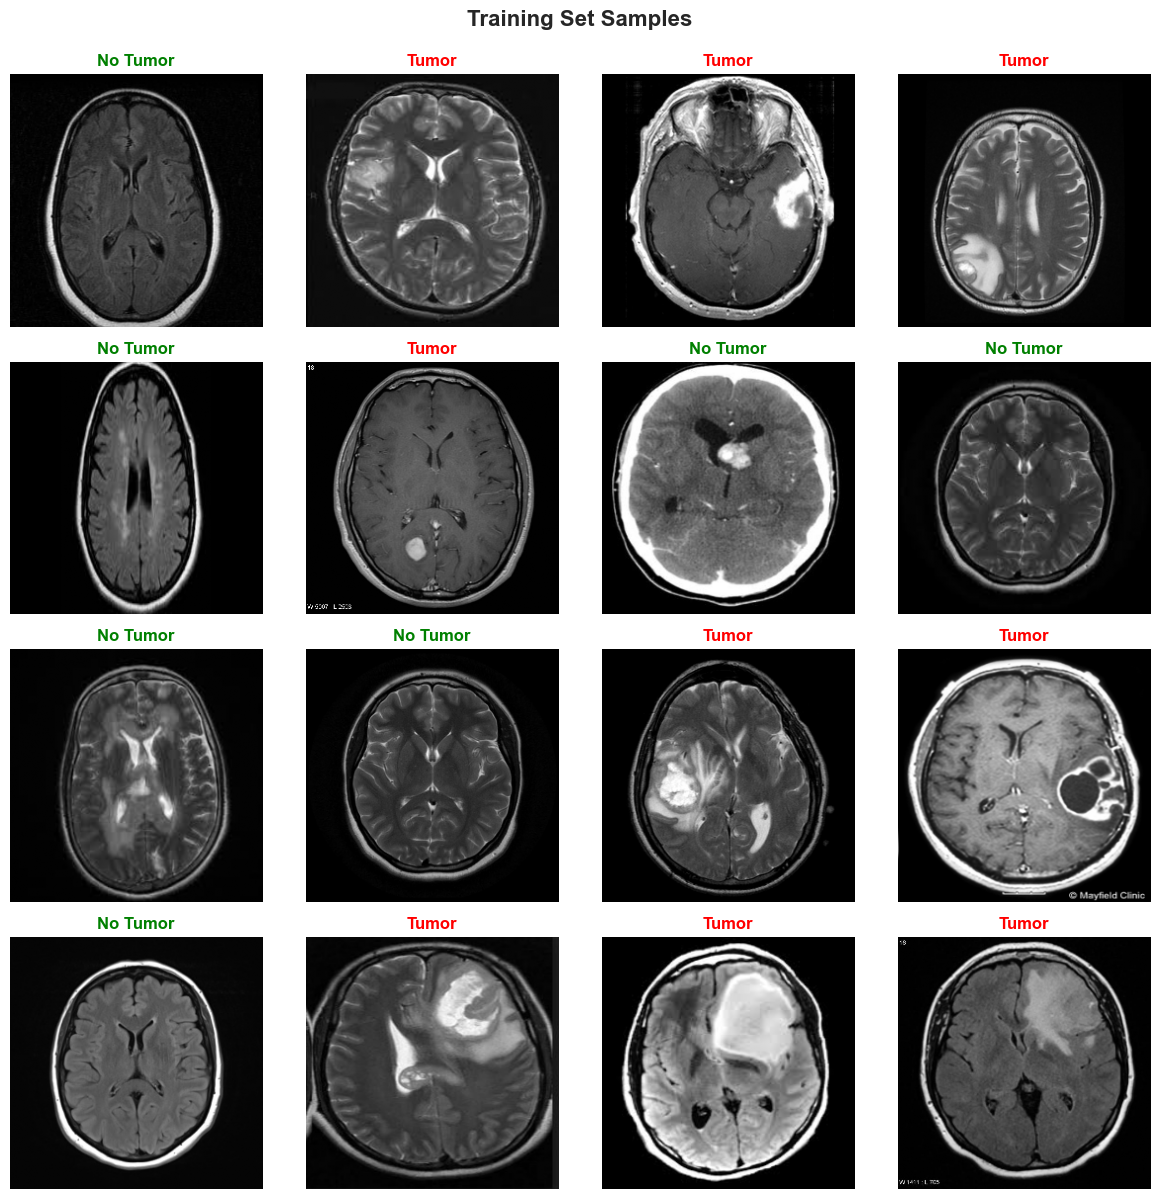

In [7]:
# ============================================================
# CELL 5: Visualize Sample Images (Grid)
# ============================================================
def visualize_samples(dataset, n_samples=16, title="Sample Images"):
    """Visualize a grid of sample images from dataset."""
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()
    
    # Get random indices
    indices = np.random.choice(len(dataset), n_samples, replace=False)
    
    for idx, ax in zip(indices, axes):
        image, label = dataset[idx]
        
        # Convert to numpy and remove channel dimension
        img = image.squeeze().numpy()
        
        # Display
        ax.imshow(img, cmap='gray')
        ax.set_title(f'{"Tumor" if label == 1 else "No Tumor"}', 
                     color='red' if label == 1 else 'green',
                     fontweight='bold')
        ax.axis('off')
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# Visualize train samples
visualize_samples(train_dataset, n_samples=16, title="Training Set Samples")


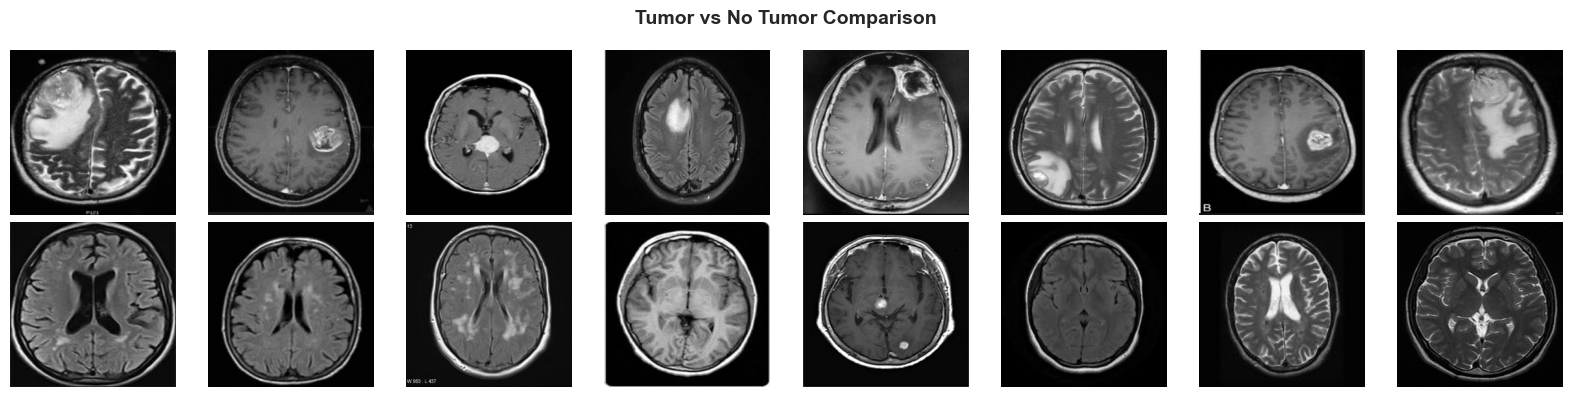

In [8]:
# ============================================================
# CELL 6: Visualize Tumor vs No Tumor Examples
# ============================================================
def visualize_comparison(dataset, n_per_class=8):
    """Show tumor vs no tumor examples side by side."""
    # Find indices for each class
    tumor_indices = [i for i in range(len(dataset)) if dataset[i][1] == 1]
    no_tumor_indices = [i for i in range(len(dataset)) if dataset[i][1] == 0]
    
    # Sample random indices
    tumor_samples = np.random.choice(tumor_indices, n_per_class, replace=False)
    no_tumor_samples = np.random.choice(no_tumor_indices, n_per_class, replace=False)
    
    fig, axes = plt.subplots(2, n_per_class, figsize=(16, 4))
    
    # Plot tumor examples
    for i, idx in enumerate(tumor_samples):
        image, _ = dataset[idx]
        axes[0, i].imshow(image.squeeze().numpy(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel('Tumor', fontsize=12, fontweight='bold')
    
    # Plot no tumor examples
    for i, idx in enumerate(no_tumor_samples):
        image, _ = dataset[idx]
        axes[1, i].imshow(image.squeeze().numpy(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_ylabel('No Tumor', fontsize=12, fontweight='bold')
    
    plt.suptitle('Tumor vs No Tumor Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_comparison(train_dataset, n_per_class=8)



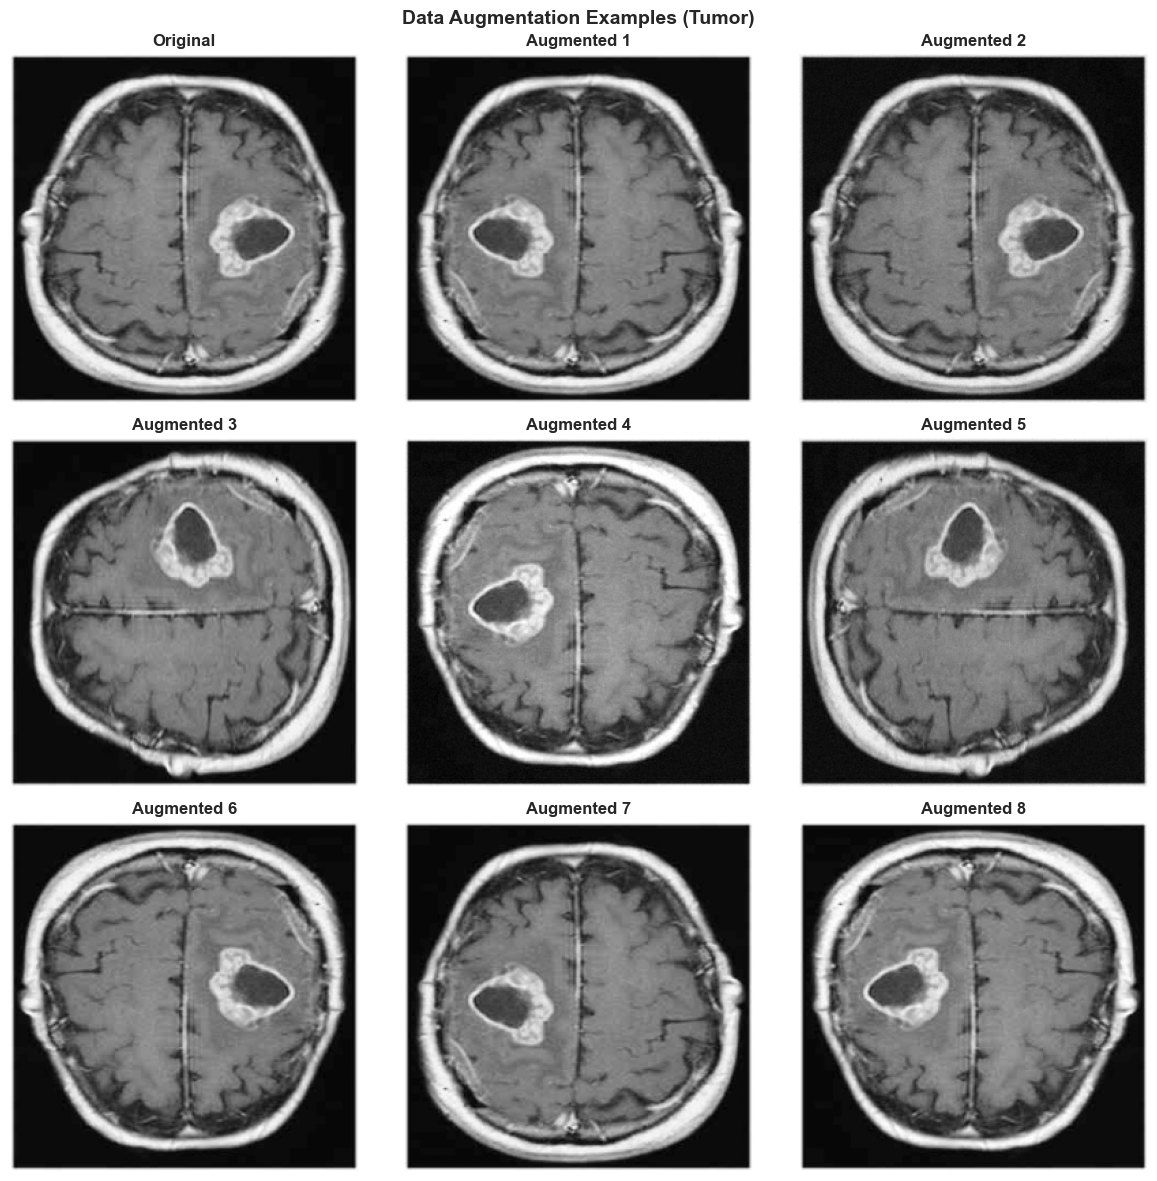

In [9]:

# ============================================================
# CELL 7: Visualize Data Augmentation
# ============================================================
def visualize_augmentations(dataset, idx=0, n_augmentations=8):
    """Show original image and multiple augmented versions."""
    # Get original image
    original_image, label = dataset[idx]
    
    # Get transform
    transform = get_train_transforms()
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()
    
    # Show original
    axes[0].imshow(original_image.squeeze().numpy(), cmap='gray')
    axes[0].set_title('Original', fontweight='bold')
    axes[0].axis('off')
    
    # Show augmented versions
    for i in range(1, 9):
        augmented = transform(original_image)
        axes[i].imshow(augmented.squeeze().numpy(), cmap='gray')
        axes[i].set_title(f'Augmented {i}', fontweight='bold')
        axes[i].axis('off')
    
    label_text = "Tumor" if label == 1 else "No Tumor"
    plt.suptitle(f'Data Augmentation Examples ({label_text})', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Show augmentation for a tumor image
tumor_idx = [i for i in range(len(train_dataset)) if train_dataset[i][1] == 1][0]
visualize_augmentations(train_dataset, idx=tumor_idx, n_augmentations=8)



In [10]:


# ============================================================
# CELL 8: Compare Augmentation Strengths
# ============================================================
def compare_augmentation_strengths(dataset, idx=0):
    """Compare light, standard, and strong augmentation."""
    original_image, label = dataset[idx]
    
    transforms = {
        'Light': get_light_train_transforms(),
        'Standard': get_train_transforms(),
        'Strong': get_strong_train_transforms(),
    }
    
    fig, axes = plt.subplots(3, 4, figsize=(14, 10))
    
    for row, (name, transform) in enumerate(transforms.items()):
        # Show original
        axes[row, 0].imshow(original_image.squeeze().numpy(), cmap='gray')
        axes[row, 0].set_title('Original' if row == 0 else '', fontweight='bold')
        axes[row, 0].set_ylabel(name, fontsize=12, fontweight='bold')
        axes[row, 0].axis('off')
        
        # Show 3 augmented versions
        for col in range(1, 4):
            augmented = transform(original_image)
            axes[row, col].imshow(augmented.squeeze().numpy(), cmap='gray')
            axes[row, col].set_title(f'Aug {col}' if row == 0 else '', fontweight='bold')
            axes[row, col].axis('off')
    
    label_text = "Tumor" if label == 1 else "No Tumor"
    plt.suptitle(f'Augmentation Strength Comparison ({label_text})', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

compare_augmentation_strengths(train_dataset, idx=tumor_idx)


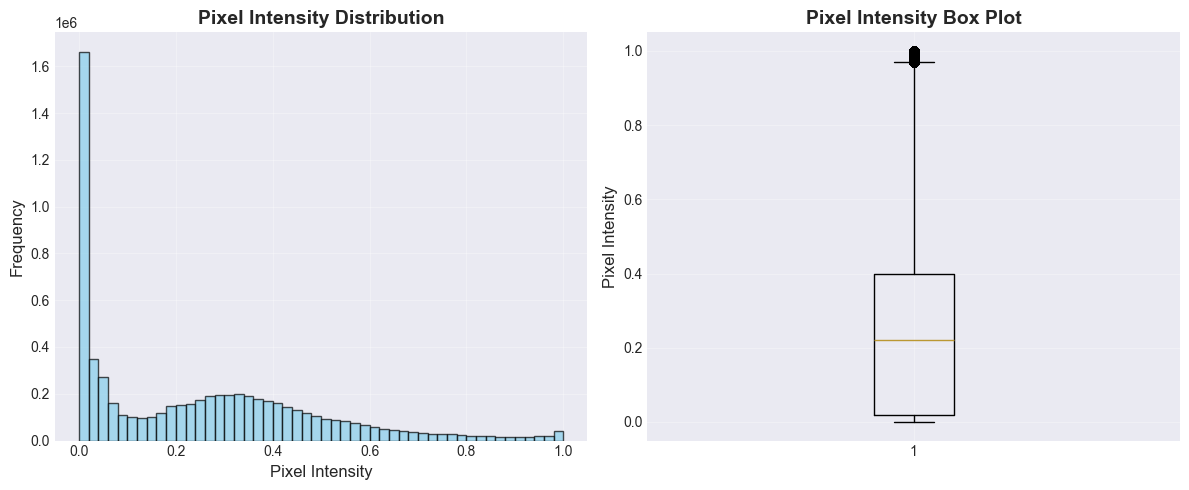


Intensity Statistics (n=100 images):
  Min:    0.0000
  Max:    1.0000
  Mean:   0.2500
  Median: 0.2209
  Std:    0.2395


In [11]:


# ============================================================
# CELL 9: Pixel Intensity Distribution
# ============================================================
def plot_intensity_distribution(dataset, n_samples=100):
    """Plot pixel intensity distribution across samples."""
    intensities = []
    
    # Sample random images
    indices = np.random.choice(len(dataset), min(n_samples, len(dataset)), replace=False)
    
    for idx in indices:
        image, _ = dataset[idx]
        intensities.extend(image.flatten().numpy())
    
    plt.figure(figsize=(12, 5))
    
    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(intensities, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Pixel Intensity', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Pixel Intensity Distribution', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Box plot
    plt.subplot(1, 2, 2)
    plt.boxplot(intensities, vert=True)
    plt.ylabel('Pixel Intensity', fontsize=12)
    plt.title('Pixel Intensity Box Plot', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nIntensity Statistics (n={n_samples} images):")
    print(f"  Min:    {np.min(intensities):.4f}")
    print(f"  Max:    {np.max(intensities):.4f}")
    print(f"  Mean:   {np.mean(intensities):.4f}")
    print(f"  Median: {np.median(intensities):.4f}")
    print(f"  Std:    {np.std(intensities):.4f}")

plot_intensity_distribution(train_dataset, n_samples=100)


In [12]:

# ============================================================
# CELL 10: DataLoader Test
# ============================================================
# Create dataloaders with absolute paths
train_loader, val_loader, test_loader = create_dataloaders(
    train_dir=str(train_dir),
    val_dir=str(val_dir),
    test_dir=str(test_dir),
    batch_size=32,
    num_workers=2,
    train_transform=get_train_transforms(),
    val_transform=get_val_transforms(),
)

print("\n" + "="*60)
print("DATALOADER VERIFICATION")
print("="*60)

print(f"\nTrain loader: {len(train_loader)} batches")
print(f"Val loader:   {len(val_loader)} batches")
print(f"Test loader:  {len(test_loader)} batches")

# Get a batch
images, labels = next(iter(train_loader))

print(f"\nBatch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Image dtype: {images.dtype}")
print(f"Image range: [{images.min():.4f}, {images.max():.4f}]")
print(f"Labels in batch: {labels.tolist()}")



DATALOADER VERIFICATION

Train loader: 6 batches
Val loader:   2 batches
Test loader:  2 batches

Batch shape: torch.Size([32, 1, 256, 256])
Labels shape: torch.Size([32])
Image dtype: torch.float32
Image range: [0.0000, 1.0000]
Labels in batch: [1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0]


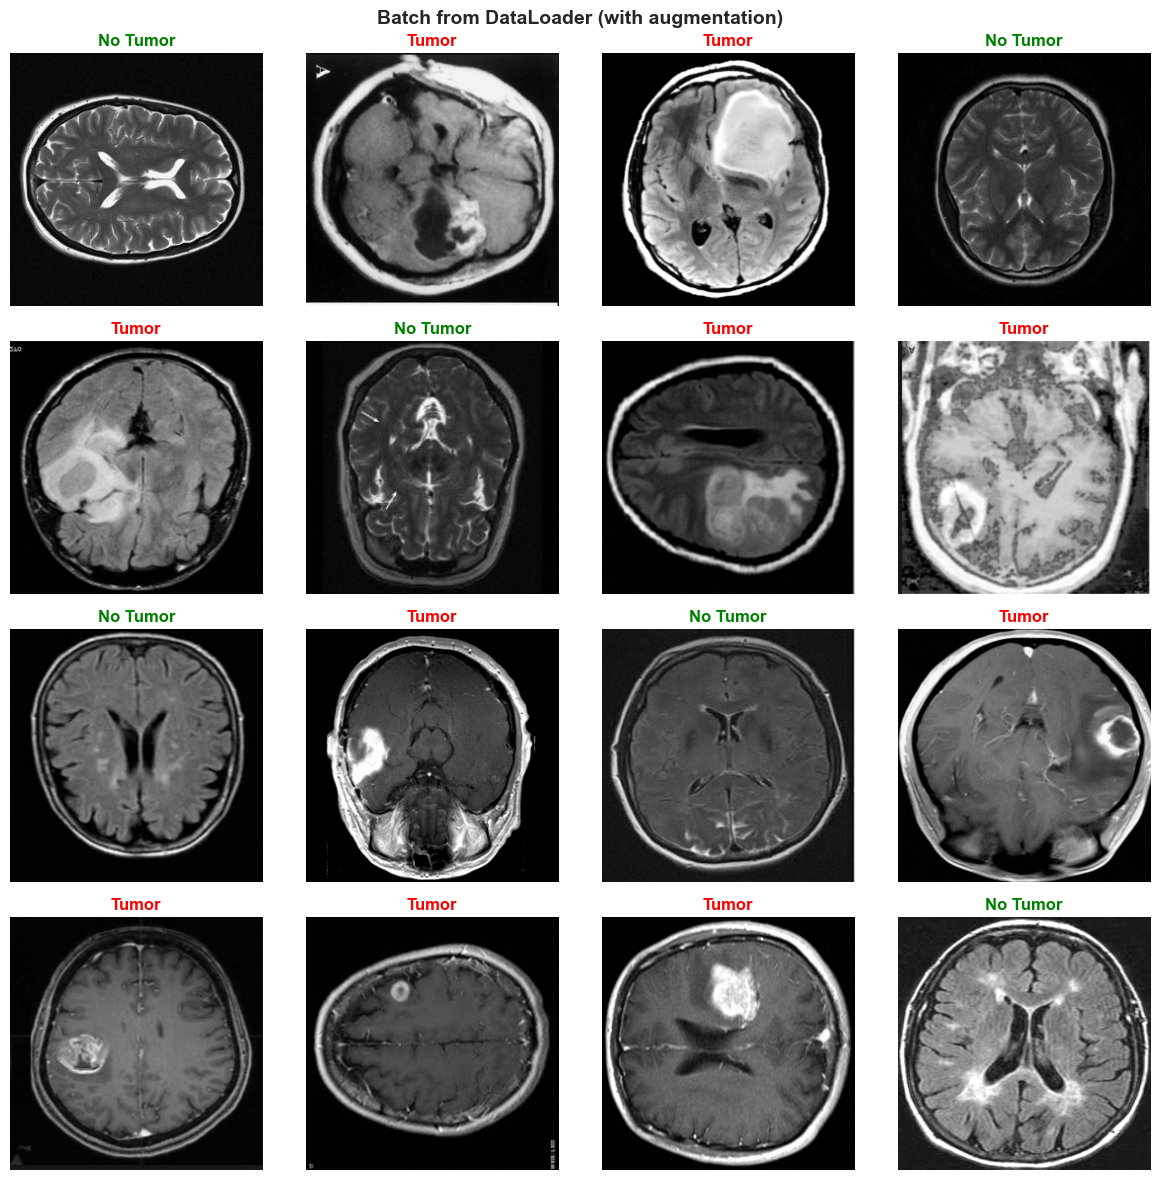

In [13]:

# ============================================================
# CELL 11: Visualize a Batch
# ============================================================
def visualize_batch(dataloader, n_images=16):
    """Visualize images from a batch."""
    images, labels = next(iter(dataloader))
    
    # Take first n_images
    images = images[:n_images]
    labels = labels[:n_images]
    
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()
    
    for i, (img, label) in enumerate(zip(images, labels)):
        axes[i].imshow(img.squeeze().numpy(), cmap='gray')
        axes[i].set_title(f'{"Tumor" if label == 1 else "No Tumor"}',
                         color='red' if label == 1 else 'green',
                         fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle('Batch from DataLoader (with augmentation)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_batch(train_loader, n_images=16)



In [14]:



# ============================================================
# CELL 12: Summary Statistics
# ============================================================
print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)

total_images = len(train_dataset) + len(val_dataset) + len(test_dataset)
total_tumor = (train_dist['tumor']['count'] + 
               val_dist['tumor']['count'] + 
               test_dist['tumor']['count'])
total_no_tumor = (train_dist['no_tumor']['count'] + 
                  val_dist['no_tumor']['count'] + 
                  test_dist['no_tumor']['count'])

print(f"\nTotal Images: {total_images}")
print(f"  - Tumor:     {total_tumor} ({total_tumor/total_images*100:.1f}%)")
print(f"  - No Tumor:  {total_no_tumor} ({total_no_tumor/total_images*100:.1f}%)")

print(f"\nSplit Sizes:")
print(f"  - Train: {len(train_dataset)} ({len(train_dataset)/total_images*100:.1f}%)")
print(f"  - Val:   {len(val_dataset)} ({len(val_dataset)/total_images*100:.1f}%)")
print(f"  - Test:  {len(test_dataset)} ({len(test_dataset)/total_images*100:.1f}%)")

print(f"\nImage Properties:")
sample_img, _ = train_dataset[0]
print(f"  - Shape:  {sample_img.shape}")
print(f"  - Dtype:  {sample_img.dtype}")
print(f"  - Range:  [{sample_img.min():.4f}, {sample_img.max():.4f}]")

print("\n[OK] All visualizations complete!")
print("[OK] Dataset is ready for training!")



DATASET SUMMARY

Total Images: 245
  - Tumor:     154 (62.9%)
  - No Tumor:  91 (37.1%)

Split Sizes:
  - Train: 171 (69.8%)
  - Val:   37 (15.1%)
  - Test:  37 (15.1%)

Image Properties:
  - Shape:  torch.Size([1, 256, 256])
  - Dtype:  torch.float32
  - Range:  [0.0000, 0.5194]

[OK] All visualizations complete!
[OK] Dataset is ready for training!
